### The FFA Algorithm

In [The Forward-Forward Algorithm: Some Preliminary
Investigations](https://www.cs.toronto.edu/~hinton/FFA13.pdf) - Geoffrey Hinton proposes an alternative to backpropagation, called the Forward-Forward Algorithm.

In FFA - the input is passed twice through the network in a forward-fashion, while no backward pass happens. Instead of a loss function, a "goodness" function is used to evaluate the predictions of the network. One of the forward passes is a "positive" pass, while the other is the "negative" pass.

- The positive pass aims to maximize the goodness on real data (actual input features and labels)
- The negative pass aims to minimize the goodness on fake data (corrupt input features and wrong labels)

While many goodness measures can be used, the paper proposes a sum of the squares of activations of intermediate ReLUs and a negative sum of the squares of activations of intermediate ReLUs.

The way data is corrupted for the negative pass is also variable - there are many ways to corrupt data. Creating masks (and inverted masks) and mixing up training data by multiplying two input feature sets with the masks and combining them into a hybrid image are used.

The following is a minimal TensorFlow-based implementation of the Forward-Forward Algorithm.

**Note:** The implementation is a work-in-progress and will periodically be updated. It's released now to (hopefully) start a discussion in this lane.

### TODO:

- Creating hybrid negative data (i.e. tf.reduce_sum(masks*input_image_pairs))
- Accounting for negative data
- Figuring out how to extract intermediate activations in TF


### Why Try To Move from Backpropagation?

Backpropagation is great! Though, it doesn't seem like it's what's happening in the brain, in which a much faster operation is taking place. In a classical deep learning workflow, we train networks in three basic steps:

- Forward pass
- Backward pass
- Updating weights

During the forward pass and backward pass, *no learning is hapenning*. Additionally, backpropagation requires the knowledge of the structure of the network during the forward pass, and is tricky for physical implementation[1](https://www.nature.com/articles/s41467-022-35216-2).

Moving away from backpropagation is likely to allow us to train networks without knowledge of the structure (or physical system), and potentially with higher efficiency.

### FFA Doesn't Replace Backpropagation

FFA, while a great step towards a broader solution, doesn't currently replace backprop and isn't meant to replace it. Some limitations and unknowns include:

- Doesn't work with networks that make use of weight-sharing (such as CNNs)
- Isn't clear how well it scales
- Requires potentially expensive creation of negative data
- Isn't faster than backprop (because two forward-passes are done)
- What makes for a good "goodness" function? Which activation functions yield the best results?


Further announced work by Geoffrey Hinton will tackle these questions. In the meantime, making the research accessible, and *inciting discussions* can help possibly derive further methods inspired by FFA.

In [1]:
import tensorflow as tf
import numpy as np

import tensorflow_datasets as tfds

2023-01-02 18:27:52.140603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(train_set, test_set), info = tfds.load("mnist", 
                                           split=["train", "test"],
                                           as_supervised=True, with_info=True)

def preprocess(img, label):
    img = tf.cast(img, tf.float32)
    return img/255.0, label

train_set = train_set.map(preprocess).batch(32)
test_set = test_set.map(preprocess).batch(32)

2023-01-02 18:27:59.501156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-01-02 18:28:01.621325: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


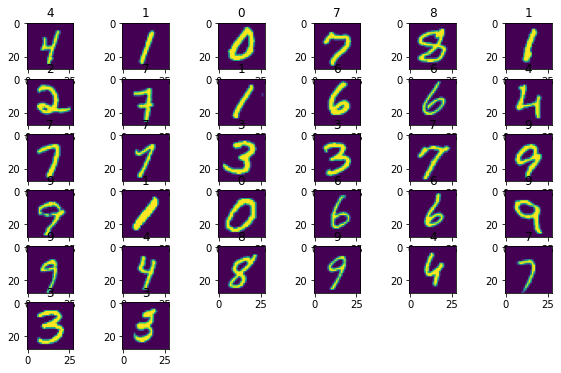

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))

for image_batch, label_batch in train_set.take(1):
    for index, image in enumerate(image_batch):
        ax = fig.add_subplot(6,6,index+1)
        ax.imshow(image)
        ax.set_title(label_batch[index].numpy())

# Classic NN with SGD

Let's start with a classic Neural Net using a "hand-made" SGD implementation.

In [4]:
from tensorflow.keras import layers

class FF(tf.keras.Model):
    def __init__(self):
        super(FF, self).__init__()
        self.flatten = layers.Flatten()
        self.d1 = layers.Dense(128)
        self.relu = layers.Activation('relu', name='relu')
        self.d2 = layers.Dense(10, activation="softmax")

    def call(self, x):
        x = self.flatten(x)
        x = self.d1(x)
        x = self.relu(x)
        x = self.d2(x)
        return x


In [5]:
model = FF()

In [6]:
epochs = 1
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
batch_size = 32

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_set):

        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
            
        grads = tape.gradient(loss_value, model.trainable_weights)
        
        # Update trainable paramms using Gradient Descent
        new_weights = model.trainable_weights - 0.01 * np.array(grads)
        for index, variable in enumerate(model.trainable_weights):
            variable.assign(new_weights[index])

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))


Start of epoch 0
Training loss (for one batch) at step 0: 2.4285
Seen so far: 32 samples


/var/folders/8_/tgk9npg5163832yrf5b5h47r0000gn/T/ipykernel_62682/3910315971.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_weights = model.trainable_weights - 0.01 * np.array(grads)


Training loss (for one batch) at step 200: 1.2834
Seen so far: 6432 samples
Training loss (for one batch) at step 400: 0.8275
Seen so far: 12832 samples
Training loss (for one batch) at step 600: 0.6614
Seen so far: 19232 samples
Training loss (for one batch) at step 800: 0.4798
Seen so far: 25632 samples
Training loss (for one batch) at step 1000: 0.5951
Seen so far: 32032 samples
Training loss (for one batch) at step 1200: 0.3196
Seen so far: 38432 samples
Training loss (for one batch) at step 1400: 0.3249
Seen so far: 44832 samples
Training loss (for one batch) at step 1600: 0.5925
Seen so far: 51232 samples
Training loss (for one batch) at step 1800: 0.5383
Seen so far: 57632 samples


In [7]:
model.summary()

Model: "ff"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  100480    
                                                                 
 relu (Activation)           multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


# FFA

In [8]:
from tensorflow.keras import layers

# Cannot use Subclassing because there is no inherennt 
# structure - the network is an arbitrary `call()` method.
# Thus, relu's output has no inbound nodes and there's no `.output`
class FF_subclass(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = layers.Flatten()
        self.d1 = layers.Dense(128)
        self.relu = layers.Activation('relu', name='relu')
        self.d2 = layers.Dense(10, activation="softmax")

    def call(self, inputs, labels):
        x = self.flatten(inputs)
        x = self.d1(x)
        x = self.relu(x)
        x = self.d2(x)
        return x

In [9]:
# Cannot use Functional because KerasTensors object has no attribute '_id'
# which is required for `tape.gradient()`.
# Functional models don't support gradient outputs as per: https://github.com/tensorflow/tensorflow/issues/46194#issuecomment-827036146
def FF_func():
    inputs = layers.Input(shape=[28, 28, 1])
    x = layers.Flatten()(inputs)
    x = layers.Dense(128)(x)
    x = layers.Activation('relu', name='relu')(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [10]:
# Functional Subclassing to the rescue?
# Clear graph structure + custom training loop and access to gradients?
from tensorflow.keras import layers

class FF(tf.keras.Model):
    def __init__(self):
        inputs = layers.Input(shape=[28, 28, 1])
        x = layers.Flatten()(inputs)
        x = layers.Dense(128)(x)
        x = layers.Activation('relu', name='relu')(x)
        output = layers.Dense(10, activation="softmax")(x)

        super().__init__(
            inputs={
                "inputs": inputs,
            },
            outputs={
                "output": output,
            },
        )

In [11]:
model = FF_func()

In [12]:
(train_set, test_set), info = tfds.load("mnist", 
                                           split=["train", "test"],
                                           as_supervised=True, with_info=True)

def preprocess(img, label):
    img = tf.cast(img, tf.float32)
    # With FFA, labels are used besides input as well.
    # Temporary workaround to mimick the regular flow
    return (img/255.0, label), label

train_set = train_set.map(preprocess).batch(32)
test_set = test_set.map(preprocess).batch(32)

In [13]:
# The 'goodness' function - with just a single layer
# returning the sum of the squares of the ReLU activations
def goodness(model, mode):
    relu_activations = model.get_layer('relu').output
    if mode=='pos':
        return tf.reduce_sum(tf.math.square(relu_activations))
    else:
        return -tf.reduce_sum(tf.math.square(relu_activations))

In [14]:
# Won't work for the same reason the Functional API won't work.

In [ ]:
epochs = 1
batch_size = 32

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    for step, ((x_batch_train, y_batch_real), y_batch_fake) in enumerate(train_set):
        with tf.GradientTape() as tape:

            positive = model(x_batch_train, y_batch_real)
            negative = model(x_batch_train, y_batch_fake)
            
            # "Loss" is the "goodness" of the hidden layers.
            # Positive pass should maximize goodness, negative pass should minimize goodness.
            positive_goodness = goodness(model, 'pos')
            negative_goodness = goodness(model, 'neg')

        grads_positive = tape.gradient(positive_goodness, model.trainable_weights)
        grads_negative = tape.gradient(negative_goodness, model.trainable_weights)
        
        # Maximize and minimize goodness
        model.trainable_weights = model.trainable_weights + lr * np.array(positive_goodness)
        model.trainable_weights = model.trainable_weights - lr * np.array(negative_goodness)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))